In [1]:
from collections import defaultdict

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import jax.numpy as jnp

from jax import random, vmap
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist

from numpyro.diagnostics import hpdi
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

In [2]:
pd.set_option('display.max_columns', 50)
numpyro.set_platform('gpu')
%matplotlib inline

In [3]:
# Types of military force
FORCE_TYPES = ("Infantry", "Cavalry", "Artillery", "Ships", "Airforce", "Special")

# Paths to data files
BATTLES_PATH = './data/bayes_battle_records.tsv'
LABELS_PATH = './data/current_run.csv'

# Some garbage still makes it through into the leaders values
# (happens because <a> tags were used, and Wikipedia sometimes links zealously)
EXCLUDED_LEADERS = set(['Capital punishment', 'Lieutenant general', '6th Panzer Army', 
                        'Navy', 'Tsar', 'Strategos', 'Knight', 'Kurdistan Democratic Party', 
                        'List of Khazar rulers', 'Commodore (rank)', 'II Corps (Pakistan)',
                        'Air marshal', 'Air chief marshal', 'Captain (armed forces)', 
                        'Campuzano Polanco family', 'XX Corps (United Kingdom)', 
                        'American Civil War', 'Israeli Navy', 'Archduke', 'Arab Liberation Army',
                        "Eighty Years' War", 'Central Command (India)', 'South Wales Borderers', 
                        'Big Red Meat', 'XI Corps (India)', 'Prime Minister of Israel', 'Army Group B', 
                        'Bangladesh Police', 'Brigadier general', 'Colonel', 'Republic of Venice', 
                        'Suicide', 'Wikimedia Error', 'Sweden', 'Wikipedia:Citation needed',
                        'Ethiopian Empire', 'Major general', 'Grand vizier', 'Germanic kingship', 
                        'Lieutenant colonel', 'Norway', 'Sir', 'Brigadier'])

# Minimum number of battles a leader must have participated in
MIN_BATTLES = 1

## Load and preprocess data

In [4]:
battles_df = pd.read_csv('./data/bayes_battle_records.tsv', sep=';', index_col=0)

hand_labels = pd.read_csv('./data/current_run.csv', index_col=0)
hand_labels['Battle'] = hand_labels.Battle.str.replace('_', ' ')

In [5]:
def get_winner(battle):
    """Return indicator for whether LHS or RHS won the battle."""
    sel = hand_labels.Battle == battle
    sel &= hand_labels.VorD == 'V'
    vrow = hand_labels.loc[sel]
    try:
        vrow = vrow.iloc[0]
        return vrow.pos
    except IndexError:
        return None

battles_df['hand_outcome'] = battles_df.index.map(get_winner)
battles_df.dropna(subset=('hand_outcome', ), inplace=True)

In [6]:
def get_forces(battle, pos, force_type):
    """Return the LHS/RHS strength count for a provided force type."""
    sel = hand_labels.Battle == battle
    sel &= hand_labels.pos == pos
    prow = hand_labels.loc[sel]

    try:
        prow = prow.iloc[0]
        return prow[force_type]
    except IndexError:
        return np.nan

for ft in FORCE_TYPES:
    battles_df[f"lhs_{ft}"] = battles_df.index.map(lambda b: get_forces(b, 'L', ft))
    battles_df[f"rhs_{ft}"] = battles_df.index.map(lambda b: get_forces(b, 'R', ft))

In [7]:
leader_counts = defaultdict(lambda: 0)
def count_leaders(leaders):
    """Increment a leader's count for each occurrence in a string."""
    for leader in leaders.split('\t'):
        if leader not in EXCLUDED_LEADERS:
            leader_counts[leader] += 1
        
    return None

battles_df.lhs_leaders.map(count_leaders)
battles_df.rhs_leaders.map(count_leaders)

# Convert to dataframe
leaders_df = pd.DataFrame.from_dict(leader_counts, orient='index', columns=['battle_count'])

In [8]:
# Filter out leaders with too few battles
# (removes some junk leaders and keeps total set small enough for MCMC)

def filter_leaders(leader_string):
    """Remove leaders who don't fight enough."""
    leaders = leader_string.split('\t')
    
    new_string = '\t'.join(l for l in leaders if l in leaders_df.index)
    
    if new_string == '':
        return None
    
    else:
        return new_string
    
leaders_df = leaders_df.loc[leaders_df.battle_count >= MIN_BATTLES]
leaders_df.sort_index(inplace=True)
leaders_df['selector'] = list(range(len(leaders_df)))

battles_df['lhs_filtered'] = battles_df.lhs_leaders.map(filter_leaders)
battles_df['rhs_filtered'] = battles_df.rhs_leaders.map(filter_leaders)
battles_df.dropna(subset=('lhs_filtered', 'rhs_filtered'), inplace=True)
battles_df.fillna(value=0, inplace=True)

In [9]:
battles_df['label'] = battles_df.hand_outcome.map({'R': 0, 'L': 1})

In [10]:
battles_df.sample(n=3)

,date,lhs_belligerents,lhs_leaders,loc,outcome,rhs_leaders,lhs_casualties,lhs_strengths,rhs_casualties,rhs_strengths,rhs_belligerents,hand_outcome,lhs_Infantry,rhs_Infantry,lhs_Cavalry,rhs_Cavalry,lhs_Artillery,rhs_Artillery,lhs_Ships,rhs_Ships,lhs_Airforce,rhs_Airforce,lhs_Special,rhs_Special,lhs_filtered,rhs_filtered,label
Battle of Walaja,May 633 A.D,Rashidun,Khalid ibn al-Walid,Mesopotamia (modern Iraq),Rashidun Caliphate victory[1],Andarzaghar\tBahman Jaduya,~2000+[2],"15,000[2]","20,000[2][3]","25,000-30,000[2]",Sasanian Empire\tWikimedia Error,L,15000.0,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Khalid ibn al-Walid,Andarzaghar\tBahman Jaduya,1
Battle of Warsaw (1920),"August 12–25, 1920",Second Polish Republic,Józef Piłsudski\tTadeusz Jordan-Rozwadowski\tW...,"Near Warsaw, Poland52°18′N 20°49′E﻿ / ﻿52.300°...",Decisive Polish victory,Leon Trotsky\tSergey Kamenev\tMikhail Tukhache...,"4,500 dead\t26,000 wounded\t10,000 missing[1]\...","113,000–135,000[1]","10,000–25,000 dead\t30,000 wounded\t65,000–85,...","104,000–140,000[1]",Russian Soviet Federative Socialist Republic,L,118000.0,122000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Józef Piłsudski\tTadeusz Jordan-Rozwadowski\tW...,Leon Trotsky\tSergey Kamenev\tMikhail Tukhache...,1
Battle of Changsha (1941),6 September – 8 October 1941,Republic of China (1912–1949),Xue Yue,Changsha,Chinese victory,Korechika Anami,Unknown[2],"300,000\t30 divisions\t631 artillery pieces[1]","Japanese claim:\t1,684 killed and missing\t5,1...","120,000 troops\t46 battalions\t326 artillery p...",Empire of Japan,L,300000.0,120000.0,0.0,0.0,631.0,326.0,0.0,0.0,0.0,0.0,0.0,0.0,Xue Yue,Korechika Anami,1


In [11]:
lhs_leaders_mat = np.zeros((len(battles_df), len(leaders_df)), dtype=int)
rhs_leaders_mat = np.zeros((len(battles_df), len(leaders_df)), dtype=int)

for bi, (battle_name, row) in enumerate(battles_df.iterrows()):
    lhs_leaders = row.lhs_filtered.split('\t')
    for leader in lhs_leaders:
        li = leaders_df.loc[leader].selector
        lhs_leaders_mat[bi, li] = 1
        
    rhs_leaders = row.rhs_filtered.split('\t')
    for leader in rhs_leaders:
        li = leaders_df.loc[leader].selector
        rhs_leaders_mat[bi, li] = 1
        
lhs_leaders_mat = jnp.device_put(lhs_leaders_mat)
rhs_leaders_mat = jnp.device_put(rhs_leaders_mat)

In [12]:
lhs_strength_mat = np.zeros((len(battles_df), len(FORCE_TYPES)))
rhs_strength_mat = np.zeros((len(battles_df), len(FORCE_TYPES)))

for bi, (battle_name, row) in enumerate(battles_df.iterrows()):
    for fi, ft in enumerate(FORCE_TYPES):
        s = row[f"lhs_{ft}"]
        if pd.notnull(s):
            lhs_strength_mat[bi, fi] = s
            
        s = row[f"rhs_{ft}"]
        if pd.notnull(s):
            rhs_strength_mat[bi, fi] = s
            
max_strengths = np.stack([lhs_strength_mat, rhs_strength_mat]).max(axis=0) + 1e-4
strength_diffs = lhs_strength_mat - rhs_strength_mat
strength_diffs /= max_strengths

strength_diffs = jnp.device_put(strength_diffs)

In [13]:
outcomes = jnp.device_put(battles_df.label.values)

In [14]:
def logistic_model(outcomes, lhs_leaders, rhs_leaders, strength_diffs):
    leaders_prior = numpyro.sample("leaders_sigma", dist.HalfCauchy(2.5))
    leader_coeffs = numpyro.sample("leader_coeffs", 
                                   dist.Normal(loc=0, scale=leaders_prior), 
                                   sample_shape=(lhs_leaders.shape[1], ))
    
    strengths_prior = numpyro.sample("strengths_sigma", dist.HalfCauchy(2.5))
    strength_coeffs = numpyro.sample("strength_coeffs", 
                                    dist.HalfNormal(scale=strengths_prior),
                                    sample_shape=(strength_diffs.shape[1], ))
    
    scores = jnp.dot(lhs_leaders, leader_coeffs) / lhs_leaders.sum(axis=1)
    scores -= jnp.dot(rhs_leaders, leader_coeffs) / rhs_leaders.sum(axis=1)
    scores += jnp.dot(strength_diffs, strength_coeffs)
    
    y = numpyro.sample("outcome", dist.Bernoulli(logits=scores), obs=outcomes)
    
    return None

In [15]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1500, 3000

# Go bananas.
kernel = NUTS(logistic_model, dense_mass=False)
mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=4, chain_method='vectorized')

mcmc.run(rng_key_, 
         outcomes=outcomes, 
         lhs_leaders=lhs_leaders_mat, rhs_leaders=rhs_leaders_mat, 
         strength_diffs=strength_diffs)

# Post-inference goodies
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 4500/4500 [03:57<00:00, 18.93it/s, None]



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
   leader_coeffs[0]     -0.22      2.32     -0.20     -3.96      3.67  21767.46      1.00
   leader_coeffs[1]      0.47      2.22      0.46     -3.25      4.01  19478.29      1.00
   leader_coeffs[2]      0.14      2.31      0.16     -3.78      3.78  23632.50      1.00
   leader_coeffs[3]      0.16      2.28      0.15     -3.44      4.06  21127.20      1.00
   leader_coeffs[4]      0.12      2.27      0.10     -3.76      3.69  22145.96      1.00
   leader_coeffs[5]      0.14      2.30      0.15     -3.46      3.98  23330.36      1.00
   leader_coeffs[6]      0.34      2.25      0.30     -3.15      4.18  20330.33      1.00
   leader_coeffs[7]     -0.21      2.29     -0.18     -3.76      3.66  22965.73      1.00
   leader_coeffs[8]     -0.22      2.28     -0.24     -3.96      3.52  21875.59      1.00
   leader_coeffs[9]     -0.53      1.74     -0.50     -3.43      2.19  15840.58      1.00
  leader_

leader_coeffs[2503]     -1.32      2.02     -1.26     -4.56      1.97   3339.74      1.00
leader_coeffs[2504]      1.17      2.03      1.09     -2.09      4.46   3516.38      1.00
leader_coeffs[2505]     -0.24      2.33     -0.23     -4.17      3.40  20250.82      1.00
leader_coeffs[2506]     -1.08      2.00     -1.00     -4.33      2.15   4838.97      1.00
leader_coeffs[2507]      0.31      1.66      0.32     -2.42      2.98  14348.59      1.00
leader_coeffs[2508]      0.47      2.29      0.42     -3.14      4.30  21640.18      1.00
leader_coeffs[2509]      0.14      2.08      0.11     -3.31      3.51  18678.57      1.00
leader_coeffs[2510]      0.78      2.17      0.74     -2.65      4.43  10349.41      1.00
leader_coeffs[2511]     -0.19      2.29     -0.19     -3.98      3.59  22650.12      1.00
leader_coeffs[2512]      0.41      2.22      0.39     -3.07      4.18  21675.70      1.00
leader_coeffs[2513]      0.31      2.27      0.30     -3.31      4.15  22128.27      1.00
leader_coe

Number of divergences: 0


In [16]:
def plot_posterior(trace, name, ax):
    leader_trace = np.asarray(trace['leader_coeffs'][:, leaders_df.loc[name].selector])
    az.plot_posterior(leader_trace,
                      kind='hist', point_estimate='mean', round_to=3,
                      ref_val=0, credible_interval=.95, rope=(-.1, .1),
                      edgecolor='white', ax=ax)
    
    plt.setp(ax, title=name)
    return ax

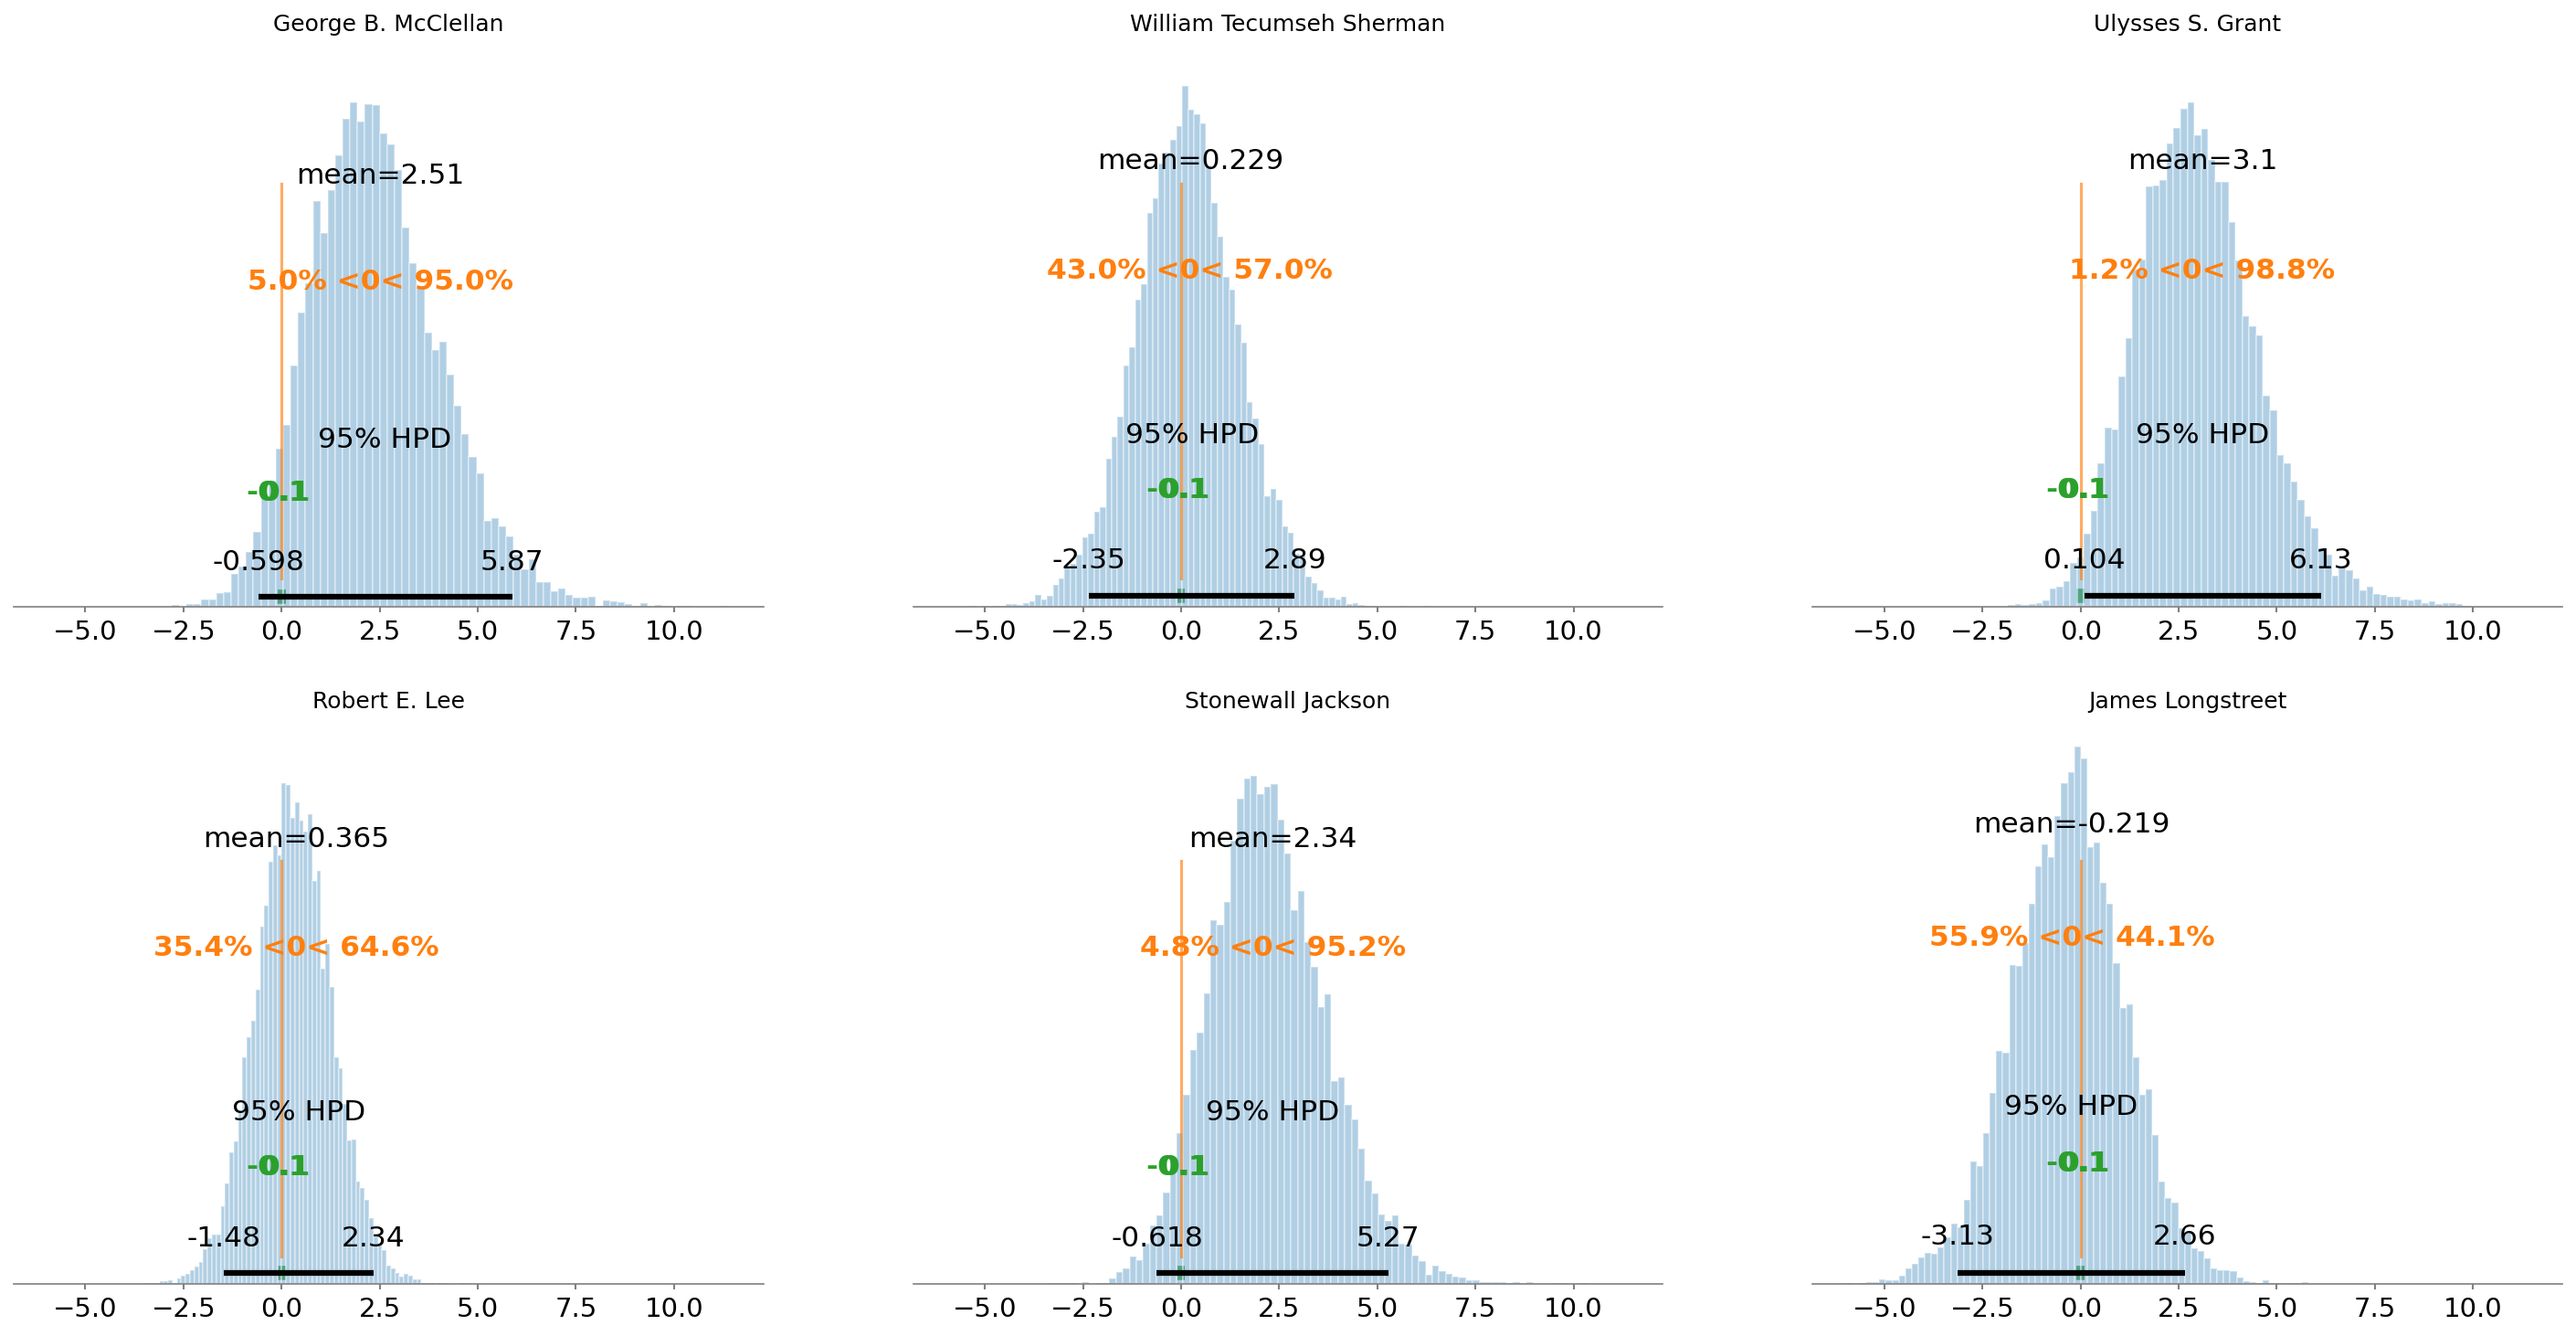

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(24, 12), dpi=150, sharey=True, sharex=True)

plot_posterior(samples, 'George B. McClellan', axes[0, 0])
plot_posterior(samples, 'William Tecumseh Sherman', axes[0, 1])
plot_posterior(samples, 'Ulysses S. Grant', axes[0, 2])
plot_posterior(samples, 'Robert E. Lee', axes[1, 0])
plot_posterior(samples, 'Stonewall Jackson', axes[1, 1])
plot_posterior(samples, 'James Longstreet', axes[1, 2]);

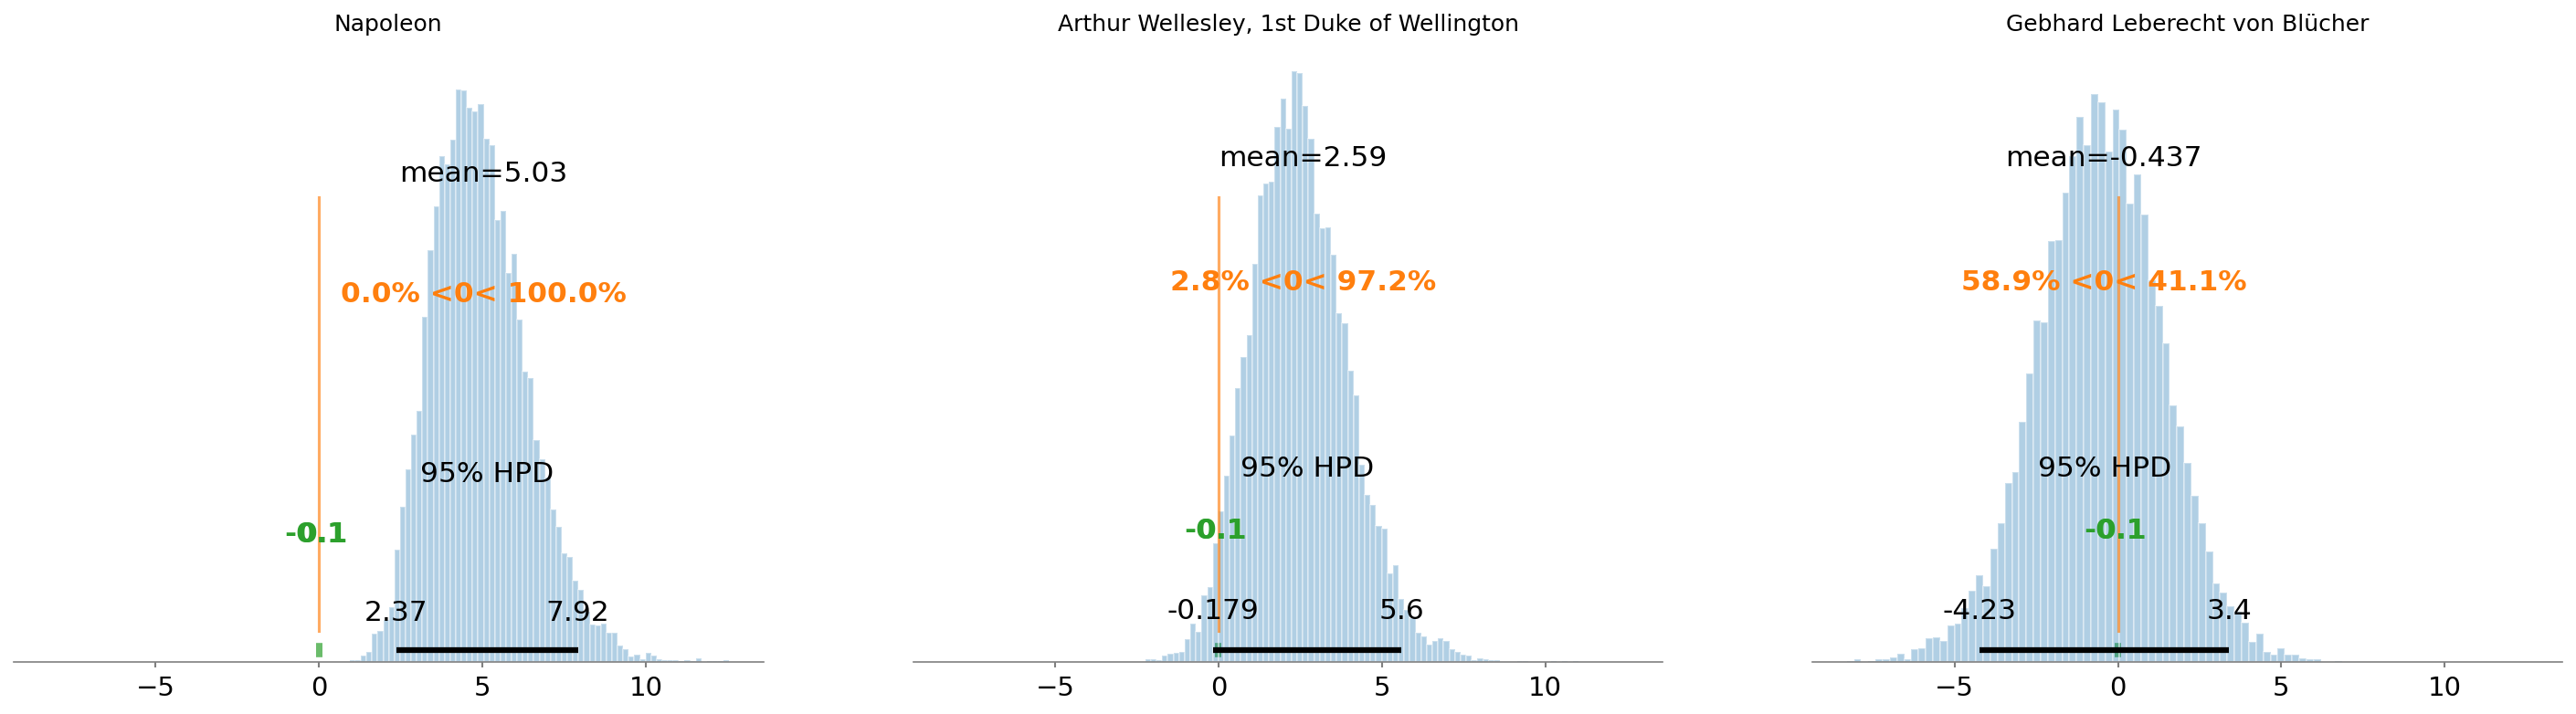

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6), dpi=150, sharex=True, sharey=True)

plot_posterior(samples, 'Napoleon', axes[0])
plot_posterior(samples, 'Arthur Wellesley, 1st Duke of Wellington', axes[1])
plot_posterior(samples, 'Gebhard Leberecht von Blücher', axes[2]);

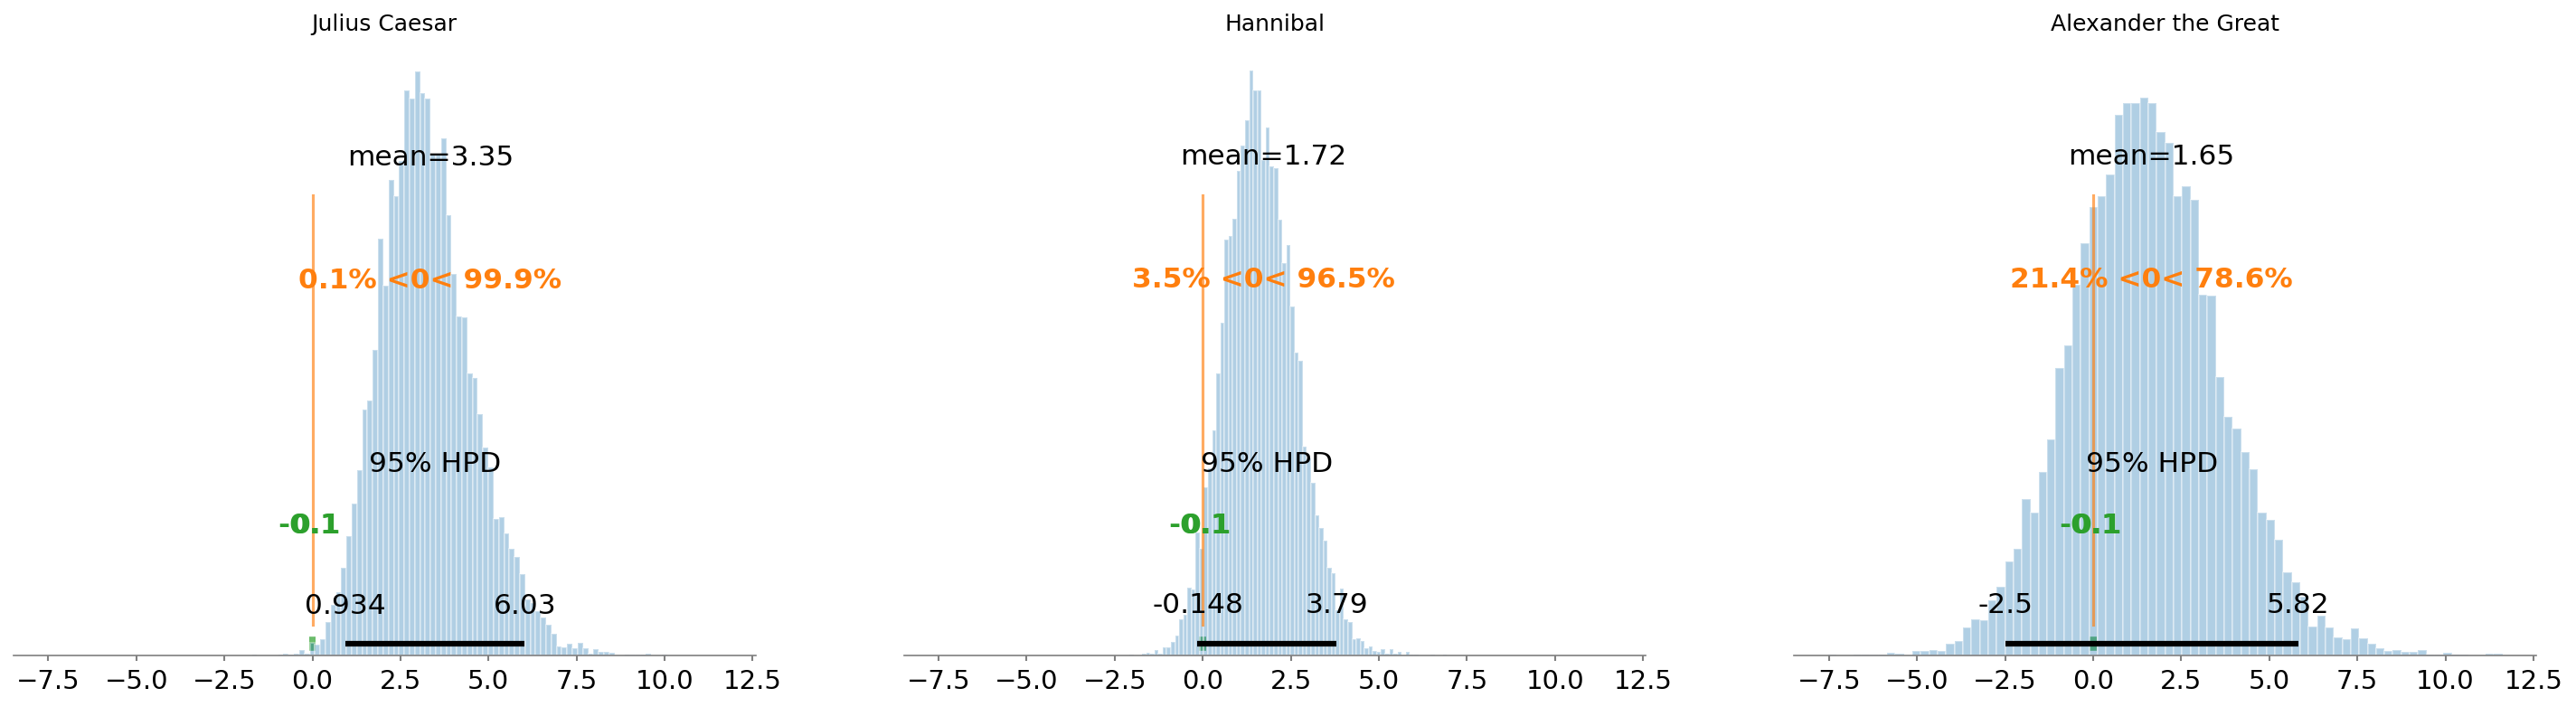

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6), dpi=150, sharex=True, sharey=True)

plot_posterior(samples, 'Julius Caesar', axes[0])
plot_posterior(samples, 'Hannibal', axes[1])
plot_posterior(samples, 'Alexander the Great', axes[2]);

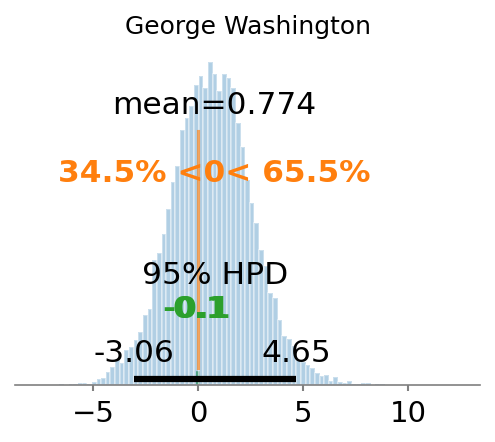

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
plot_posterior(samples, 'George Washington', axes);

In [26]:
def plot_diff(trace, name0, name1, ax):
    leader_trace_0 = np.asarray(trace['leader_coeffs'][:, leaders_df.loc[name0].selector])
    leader_trace_1 = np.asarray(trace['leader_coeffs'][:, leaders_df.loc[name1].selector])
    
    leader_trace = leader_trace_0 - leader_trace_1
    
    az.plot_posterior(leader_trace,
                      kind='hist', point_estimate='mean', round_to=3,
                      ref_val=0, credible_interval=.95, rope=(-.1, .1),
                      edgecolor='white', ax=ax)
    
    plt.setp(ax, title=f"{name0} VS {name1}")
    return ax

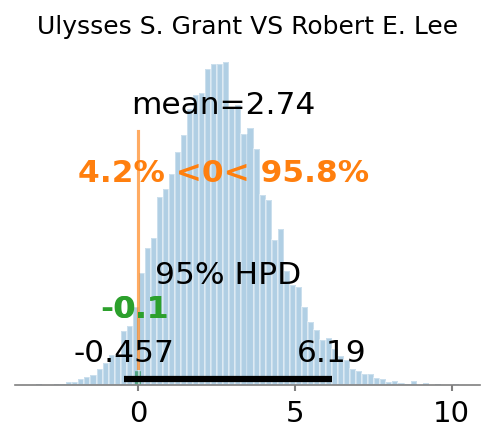

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
plot_diff(samples, 'Ulysses S. Grant', 'Robert E. Lee', axes);

In [32]:
def plot_coeff_posterior(trace, name, ax):
    idx = FORCE_TYPES.index(name)
    force_trace = np.asarray(trace["strength_coeffs"][:, idx])
    
    az.plot_posterior(force_trace,
                      kind='hist', point_estimate='mean', round_to=3,
                      ref_val=0, credible_interval=.95, rope=(-.1, .1),
                      edgecolor='white', ax=ax);
    
    plt.setp(ax, title=name)
    return ax

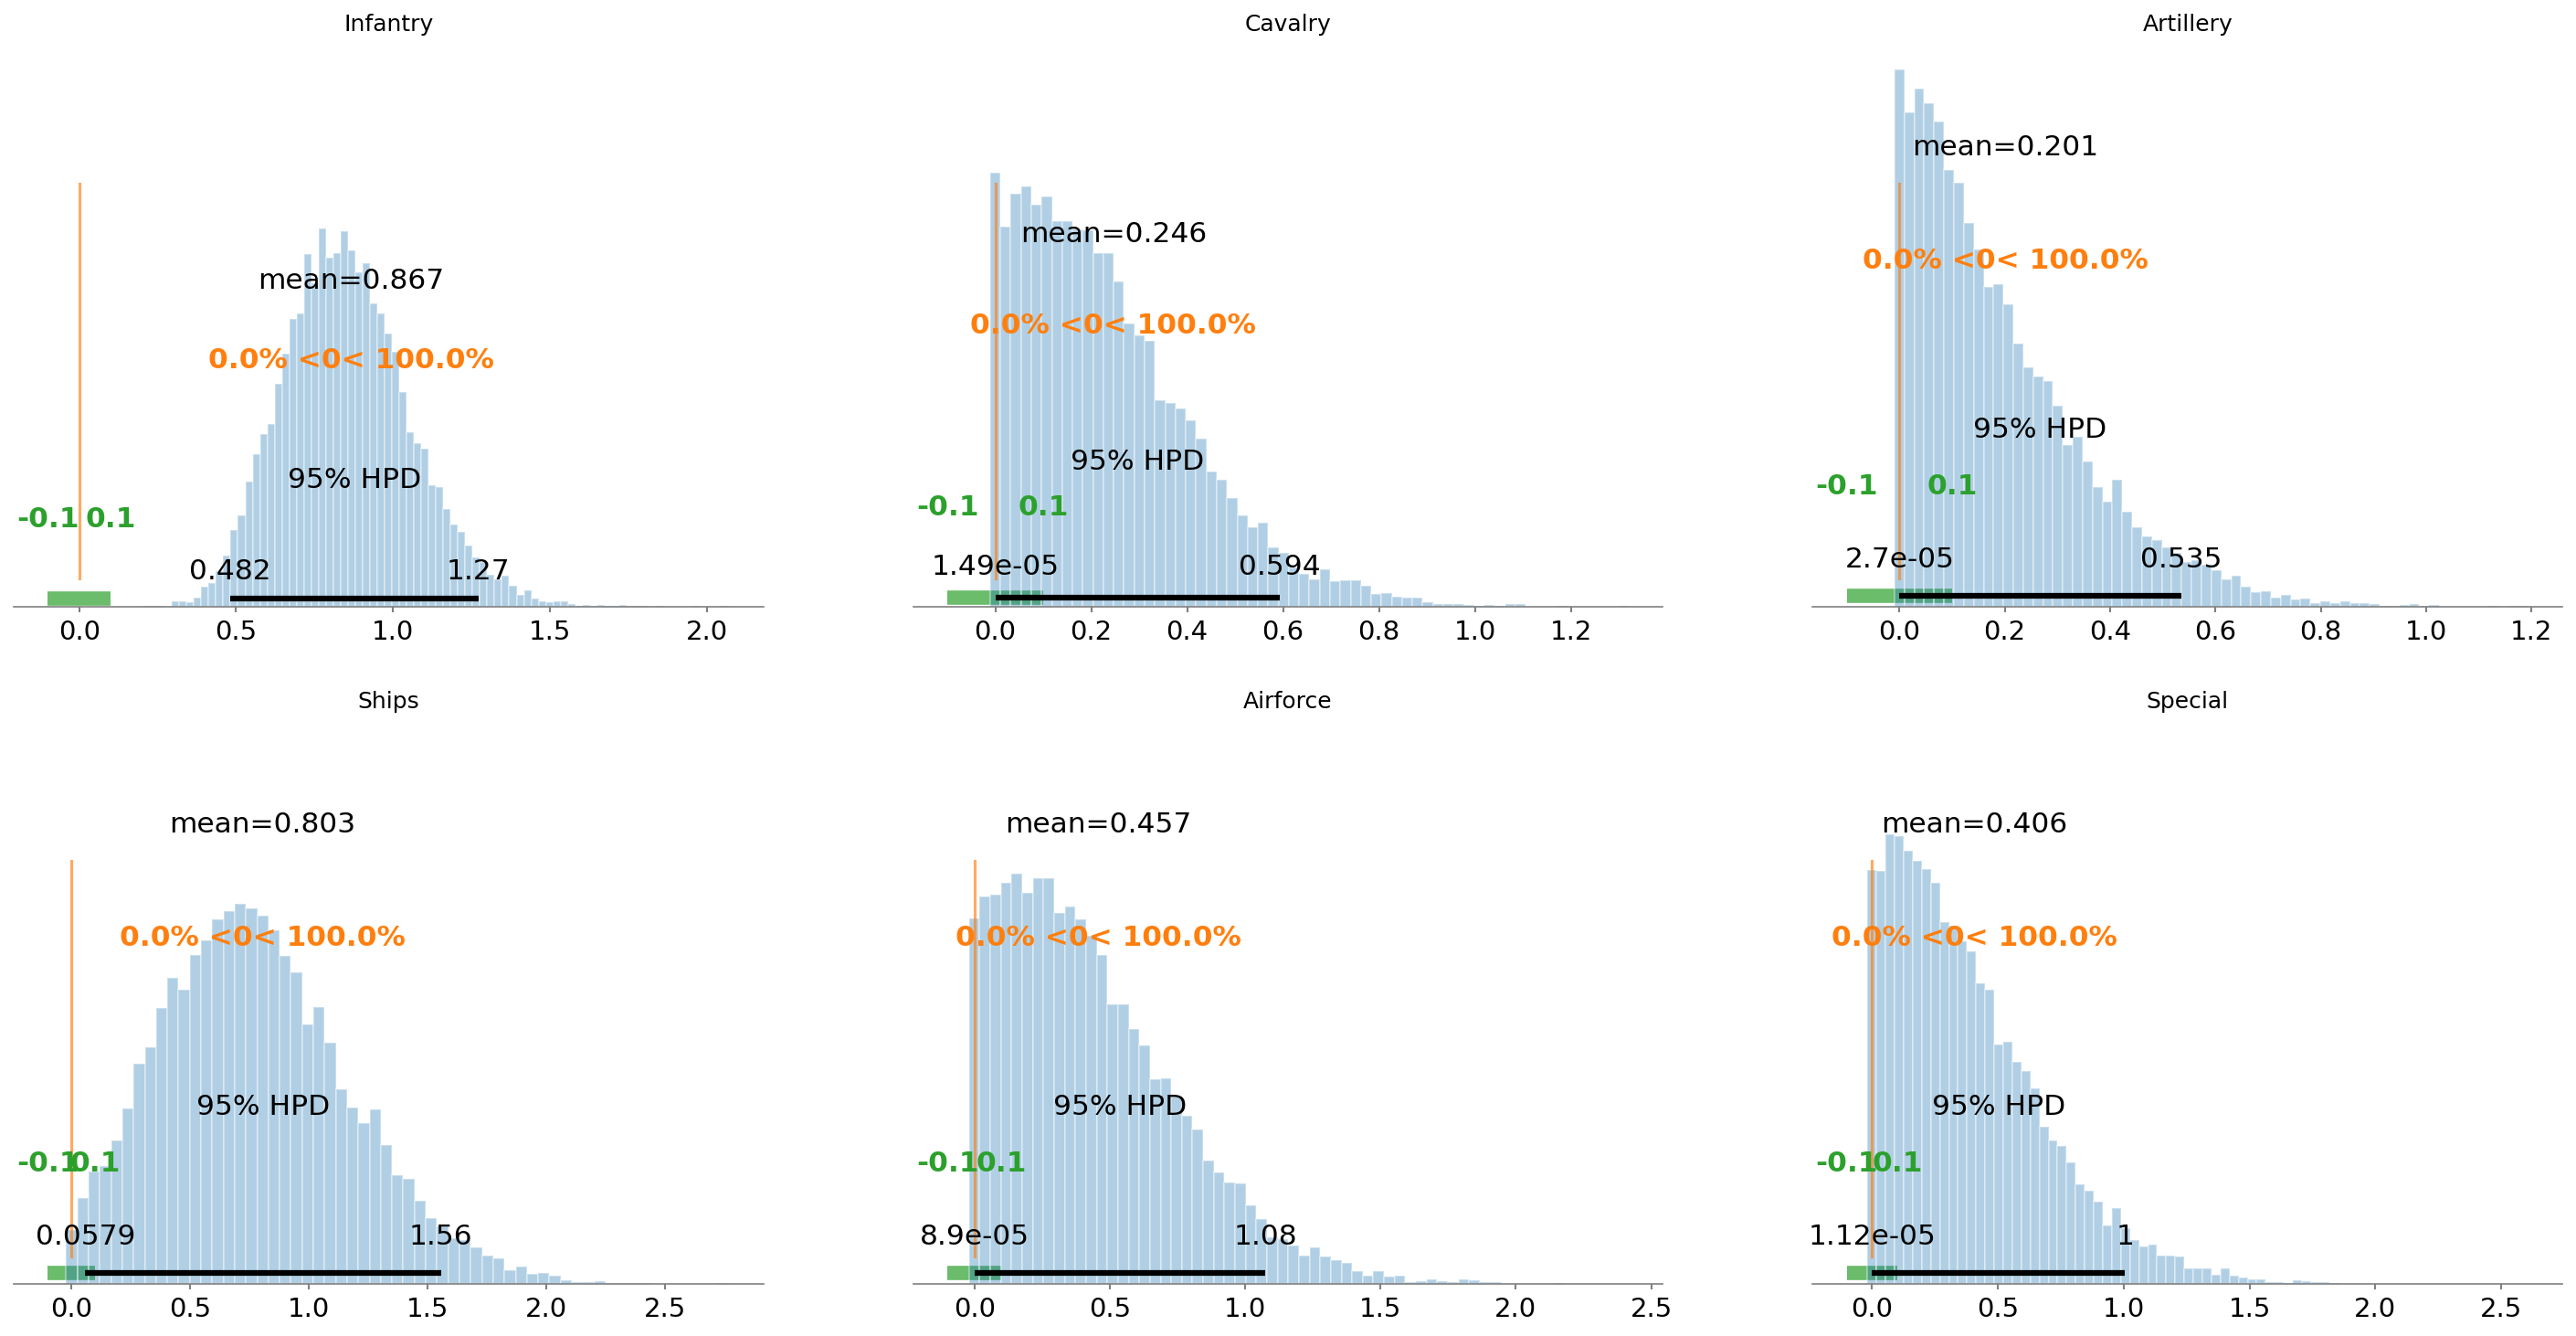

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(24, 12), dpi=150, sharey=True)
for i, ax in enumerate(axes.flatten()):
    ft = FORCE_TYPES[i]
    plot_coeff_posterior(samples, ft, ax)